# Quantify interaction between theta and low-gamma

In [2]:
## plot
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

## operations
import numpy as np
from scipy.io import loadmat
from scipy import signal
from scipy.signal import butter, lfilter, hilbert, chirp
from scipy import stats
from scipy.stats import binned_statistic


## time_frequency
import mne
from mne.time_frequency import tfr_array_multitaper, psd_array_multitaper
from mne.stats import permutation_cluster_1samp_test, permutation_cluster_test


## pac
# from pactools import Comodulogram, REFERENCES
# from pactools import simulate_pac

import pandas as pd

from statsmodels.formula.api import ols, mixedlm
import statsmodels.api as sm

## Saving data dictionaries
import pickle

import PyQt5

# Load study related info

In [4]:
## Load study related info
with open('../Results/study_info.pickle', 'rb') as handle:
    study_info = pickle.load(handle,encoding='latin1')
    

density        = study_info['density'] 
speed          = study_info['speed'] 
dd             = study_info['dd'] ## Number of sensory cues (density)
dur            = study_info['dur'] ## Trial duration (sec)
K_i_idx        = study_info['K_i_idx']
K_i            = study_info['K_i']
uni            = study_info['uni']
t_dur          = study_info['t_dur']
t_dd           = study_info['t_dd']
sessions       = study_info['sessions'] 
ttl_idx        = study_info['ttl_idx']
hpc_electrodes = study_info['hpc_electrodes']
fs             = study_info['fs']



## Load trial markers for each session
with open('../Results/trials_markers.pickle', 'rb') as handle:
    trials_markers = pickle.load(handle,encoding='latin1')

# Util functions for signal processing

In [182]:
def hilbert_transform(tmp_lfp_notch, fs, l_f_amp,h_f_amp):

    info = mne.create_info(ch_names=['lfp'], sfreq=fs, ch_types=['eeg'])
    raw = mne.io.RawArray([tmp_lfp_notch], info)

    raw_band = raw.copy()
    raw_band.filter(2, 8, l_trans_bandwidth=2., h_trans_bandwidth=2., fir_design='firwin')
    raw_hilb = raw_band.copy()
    hilb_picks = mne.pick_types(raw_band.info, meg=False, eeg=True)
    raw_hilb.apply_hilbert(hilb_picks)
    raw_phase = raw_hilb.copy()
    raw_phase.apply_function(np.angle, hilb_picks)
    raw_phase = raw_phase.get_data()[0].real

    raw_band = raw.copy()
    raw_band.filter(l_f_amp,h_f_amp, l_trans_bandwidth=2., h_trans_bandwidth=2., fir_design='firwin')
    raw_hilb = raw_band.copy()
    hilb_picks = mne.pick_types(raw_band.info, meg=False, eeg=True)
    raw_hilb.apply_hilbert(hilb_picks)
    raw_amp = raw_hilb.copy()
    raw_amp.apply_function(np.abs, hilb_picks)
    raw_amp = raw_amp.get_data()[0].real

    return raw_phase, raw_amp




def hilbert_transform_get_component(tmp_lfp_notch, fs, low_amp_freq,high_amp_freq, component):
    
    '''
    Transform signal and get either phase or amplitude component
    component: 'phase' or 'amplitude'
    '''

    info = mne.create_info(ch_names=['lfp'], sfreq=fs, ch_types=['eeg'])
    raw = mne.io.RawArray([tmp_lfp_notch], info)
    
    if component == 'phase':

        raw_band = raw.copy()
        raw_band.filter(low_amp_freq,high_amp_freq, l_trans_bandwidth=2., h_trans_bandwidth=2., fir_design='firwin')
        raw_hilb = raw_band.copy()
        hilb_picks = mne.pick_types(raw_band.info, meg=False, eeg=True)
        raw_hilb.apply_hilbert(hilb_picks)
        raw_out = raw_hilb.copy()
        raw_out.apply_function(np.angle, hilb_picks)
        raw_out = raw_out.get_data()[0].real
        
    if component == 'amplitude':


        raw_band = raw.copy()
        raw_band.filter(low_amp_freq,high_amp_freq, l_trans_bandwidth=2., h_trans_bandwidth=2., fir_design='firwin')
        raw_hilb = raw_band.copy()
        hilb_picks = mne.pick_types(raw_band.info, meg=False, eeg=True)
        raw_hilb.apply_hilbert(hilb_picks)
        raw_out = raw_hilb.copy()
        raw_out.apply_function(np.abs, hilb_picks)
        raw_out = raw_out.get_data()[0].real

    return raw_out





def calculate_KB(bs):

    'PAD is the phase amp distribution'
    pad = bs[0]
    pad_2 = np.hstack((pad , pad))

    num_bins = pad_2.size
    n_pevents = float(np.sum(pad_2))
    ppp = -1 * np.sum((pad_2/n_pevents) * np.log((pad_2/n_pevents)))
    K_L = (np.log(num_bins) - ppp) / np.log(num_bins)

    return K_L


# Compute coupling

In [57]:
l_f_amp,h_f_amp= 55,95


amp_phase = {}

### Run each session
for sub in range(len(sessions)):
    
    amp_phase[sub] = {}
    amp_phase[sub]['phase'] = []
    amp_phase[sub]['amp'] = []
    
    ### Load this session dataset
    lfp = loadmat('../Data/'+sessions[sub]+'.mat')
    lfp = lfp['ourData']
    
    
    ### Loop through this session/patient hippocampal channel
    for cc in hpc_electrodes[sub]:
        
        ### Get this channel LFP 
        tmp_lfp = lfp[cc]         
        
        tmp_lfp_notch = mne.filter.notch_filter( np.float64(tmp_lfp), fs, [50,100,150,200], notch_widths=20 )
        raw_phase, raw_amp = hilbert_transform(tmp_lfp_notch, fs,l_f_amp,h_f_amp)

        amp_phase[sub]['phase'].append( raw_phase)
        amp_phase[sub]['amp'].append( raw_amp)

Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=209001
    Range : 0 ... 209000 =      0.000 ...   408.203 secs
Ready.
Setting up band-pass filter from 2 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-pass filter from 55 - 95 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=209001
    Range : 0 ... 209000 =      0.000 ...   408.203 secs
Ready.
Setting up band-pass filter from 2 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-pass filter from 55 - 95 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=209001
    Range : 0 ... 209000 =      0.000 ...   408.203 secs
Ready.
S

Setting up band-pass filter from 55 - 95 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=205501
    Range : 0 ... 205500 =      0.000 ...   401.367 secs
Ready.
Setting up band-pass filter from 2 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-pass filter from 55 - 95 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=205501
    Range : 0 ... 205500 =      0.000 ...   401.367 secs
Ready.
Setting up band-pass filter from 2 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-pass filter from 55 - 95 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, 

# Distribution of PAC
### All trials

In [58]:
trial_begin           = 0
trial_end             = 1500#4000
# trial_begin           = 0
# trial_end             = 1500


## Trial type
tmp_density = np.tile( np.repeat( np.arange(3), 3 ),3)
tmp_speed = np.tile( np.arange(3), 9 )
tmp_dur = [ 18.1, 13.5, 11]
tmp_dd = [50,100,150]


log_pac = []
for sub in range(len(sessions)):

    idx_trials = trials_markers[sessions[sub]]

    
    for cc in range(len(amp_phase[sub]['amp'])):

        tmp_amp = amp_phase[sub]['amp'][cc]
        tmp_phase = amp_phase[sub]['phase'][cc]

        
        for trial in range(len(idx_trials)):
            
            tmp_tmp_amp = tmp_amp[ idx_trials[trial] + trial_begin : idx_trials[trial] + trial_end ]
            tmp_tmp_phase = tmp_phase[ idx_trials[trial] + trial_begin : idx_trials[trial] + trial_end ]
            
            bs = binned_statistic(tmp_tmp_phase,tmp_tmp_amp)
            kb = calculate_KB(bs)

            cs = tmp_dd[tmp_density[trial]]/tmp_dur[tmp_speed[trial]]
            csw = np.argmin(np.abs(cs-np.linspace(2,14,4)))
            log_pac.append( [sub, tmp_density[trial], tmp_speed[trial], cs, csw, kb] )
            
            
            

In [59]:
log_pac = pd.DataFrame(log_pac, columns=['sub','density','speed','cuesec','cuesec_w','kb'] )

              sum_sq     df         F    PR(>F)
kb          0.383734    1.0  0.574589  0.448662
Residual  539.616266  808.0       NaN       NaN
              sum_sq     df         F    PR(>F)
kb          2.417827    1.0  3.634057  0.056963
Residual  537.582173  808.0       NaN       NaN


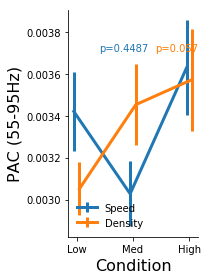

In [60]:
fig = plt.figure()
ax = fig.add_subplot(111)

fig.set_figheight(4)
fig.set_figwidth(3)

var_of_interst = 'kb'


mmd = log_pac.groupby(['density']).mean()[var_of_interst]
mms = log_pac.groupby(['speed']).mean()[var_of_interst]

ssd = log_pac.groupby(['density']).sem()[var_of_interst]
sss = log_pac.groupby(['speed']).sem()[var_of_interst]

plt.errorbar(  np.arange(3)-0.05, mms, yerr=sss, label='Speed', linewidth=3 )
plt.errorbar(  np.arange(3)+0.05, mmd, yerr=ssd, label='Density', linewidth=3  )


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.sca(ax)
plt.legend( frameon=False, loc='lower left')

plt.ylabel('PAC (' + str(l_f_amp) +'-'+str(h_f_amp)+'Hz)'  , fontsize=16)
plt.xlabel('Condition', fontsize=16)

plt.xticks(range(3), ['Low','Med','High'])

plt.tight_layout()
# plt.savefig('../Figures/theta_dominant_freq_both.pdf')




# plt.ylim(0.0015,0.003)

new_blue   = '#1f77b4'
new_orange = '#ff7f03'

ym = plt.ylim()[1]*0.95

cw_lm=ols('speed ~ ' + var_of_interst , data=log_pac).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=2))
pval_str =   'p=' + str(np.round(sm.stats.anova_lm(cw_lm, typ=2)['PR(>F)']['kb'],4))
plt.text( 0.4, ym, pval_str,  fontdict=dict(color=new_blue) )


cw_lm=ols('density ~ ' + var_of_interst , data=log_pac).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=2))
pval_str =   'p=' + str(np.round(sm.stats.anova_lm(cw_lm, typ=2)['PR(>F)']['kb'],4))
plt.text( 0.4+1, ym, pval_str,  fontdict=dict(color=new_orange) )

plt.tight_layout()
# plt.savefig('../Figures/pac_condition.pdf')

Pearson:  (0.08744045896813613, 0.012791366941120656)
              sum_sq     df         F    PR(>F)
kb          5.564057    1.0  6.292737  0.012318
Residual  714.435943  808.0       NaN       NaN


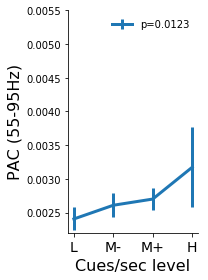

In [61]:
mmcs = log_pac.groupby(['cuesec_w']).median()[var_of_interst]
sscs = log_pac.groupby(['cuesec_w']).sem()[var_of_interst]


fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figheight(4)
fig.set_figwidth(3)



print( 'Pearson: ',  stats.pearsonr(log_pac.cuesec, log_pac[var_of_interst] ))
cw_lm=ols('cuesec_w ~ ' + var_of_interst , data=log_pac).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=2))
ym = sum(plt.ylim())/2.4
pval_str =   'p=' + str(np.round(sm.stats.anova_lm(cw_lm, typ=2)['PR(>F)']['kb'],4))


# ax.errorbar( uni, mmcs, yerr=sscs, linewidth=3 )
ax.errorbar(  range(mmcs.size), mmcs, yerr=sscs, linewidth=3, label=pval_str )
plt.legend(frameon=False, loc='best')

fig.patch.set_facecolor('xkcd:white')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.sca(ax)
plt.ylabel('PAC (' + str(l_f_amp) +'-'+str(h_f_amp)+'Hz)'  , fontsize=16)
plt.xlabel('Cues/sec level', fontsize=16)

plt.ylim(0.0022,0.0055)
plt.xticks(  range(mmcs.size), ['L','M-','M+','H'], fontsize=14 )
plt.tight_layout()
# plt.savefig('../Figures/pac_cuesec.pdf')

Pearson:  (0.021575706184464402, 0.5397583519343638)
               sum_sq     df         F    PR(>F)
kb           4.320066    1.0  0.376308  0.539758
Residual  9275.944793  808.0       NaN       NaN


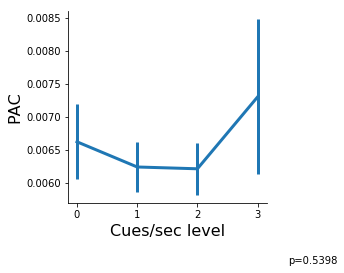

In [15]:
mmcs = log_pac.groupby(['cuesec_w']).mean()[var_of_interst]
sscs = log_pac.groupby(['cuesec_w']).sem()[var_of_interst]


fig = plt.figure()
ax = fig.add_subplot(111)

fig.set_figheight(4)
fig.set_figwidth(5)


# ax.errorbar( uni, mmcs, yerr=sscs, linewidth=3 )
ax.errorbar(  range(mmcs.size), mmcs, yerr=sscs, linewidth=3 )

# sns.violinplot(data=log_wel_all.groupby(['cuesec']),  palette="Set3", bw=1.2, cut=2, linewidth=1 )


fig.patch.set_facecolor('xkcd:white')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.sca(ax)

plt.ylabel('PAC', fontsize=16)
plt.xlabel('Cues/sec level', fontsize=16)

# plt.ylim(8,12)
# plt.xticks(  range(mmcs.size), ['L','M-','M+','H'], fontsize=14 )

# ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.4f'))
# ax.set_yscale("log")



print( 'Pearson: ',  stats.pearsonr(log_pac.cuesec, log_pac[var_of_interst] ))

cw_lm=ols('cuesec ~ ' + var_of_interst , data=log_pac).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=2))

ym = sum(plt.ylim())/3
pval_str =   'p=' + str(np.round(sm.stats.anova_lm(cw_lm, typ=2)['PR(>F)']['kb'],4))
plt.text( 3.5, ym, pval_str )

# plt.savefig('../Figures/theta_dominant_freq_cues_per_sec.pdf')
plt.tight_layout()
# plt.savefig('../Figures/pac_cuesec.pdf')

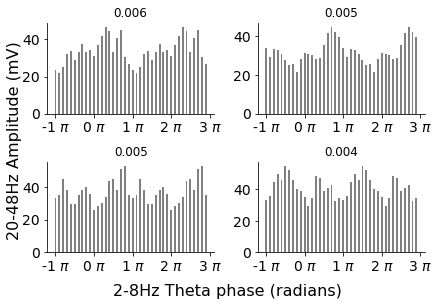

In [16]:
sub = 4
cc = 0

tmp_amp = amp_phase[sub]['amp'][cc]
tmp_phase = amp_phase[sub]['phase'][cc]

idx_trials = trials_markers[sessions[sub]]



fig = plt.figure()
# ax = fig.add_subplot(111)
fig.set_figheight(4)
fig.set_figwidth(6)



for trial in range(4):
    

    tmp_tmp_amp = tmp_amp[ idx_trials[trial] + trial_begin : idx_trials[trial] + trial_end ]
    tmp_tmp_phase = tmp_phase[ idx_trials[trial] + trial_begin : idx_trials[trial] + trial_end ]

    bs = binned_statistic(tmp_tmp_phase,tmp_tmp_amp,bins=20)
    kb = calculate_KB(bs)
    
    
    
    ax = plt.subplot(2,2,trial+1)
    plt.bar(  bs[1][:-1]/np.pi , bs[0] , width=0.05, color='grey' )
    plt.bar(  (bs[1][:-1] + np.pi*2)/np.pi , bs[0] , width=0.05, color='grey' )
    ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g $\pi$'))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)


    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.title(np.round(kb,3))
    plt.sca(ax)
#     plt.ylabel('Amplitude (mV)', fontsize=14)
#     plt.xlabel('Phase (radians)', fontsize=14)
    
    
    
fig.text(0.5, -0.04, '2-8Hz Theta phase (radians)', ha='center', fontsize=16)
fig.text(-0.01, 0.5, '20-48Hz Amplitude (mV)', va='center', rotation='vertical', fontsize=16)


fig.patch.set_facecolor('xkcd:white')
plt.tight_layout()


# plt.savefig('../Figures/pac_examples.pdf', bbox_inches='tight')

# Ratio theta dominant frequency and theta-gamma PAC

In [150]:
log_welch_dom_freq = np.load('../Results/log_welch_0_1500_4_28_15_2.npy',encoding='latin1')

dom_freq = []

for ss in range(len(log_welch_dom_freq)):
    
    for tt in range(len(log_welch_dom_freq[ss])):
        
        
        cs = log_welch_dom_freq[ss][tt][3]
        csw = np.argmin(np.abs(cs-np.linspace(2,14,4)))
        dom_freq.append( [ ss, log_welch_dom_freq[ss][tt][1] , log_welch_dom_freq[ss][tt][2] , cs , csw, log_welch_dom_freq[ss][tt][4] ] )
        
        
dom_freq = np.array(dom_freq)

dom_freq = pd.DataFrame(dom_freq, columns=['sub','density','speed','cuesec', 'cuesec_w', 'freq'] )

dom_freq['kb'] = log_pac['kb']  ## add pac data to this dataframe
dom_freq['freq_kb_ratio'] =   dom_freq['freq']/dom_freq['kb']

Pearson:  (0.0914395082034596, 0.009218260280762688)
             sum_sq     df         F    PR(>F)
freq        5.63117    1.0  6.369238  0.011802
Residual  714.36883  808.0       NaN       NaN


Text(0.5, 4.768856447688565, 'p=0.0118')

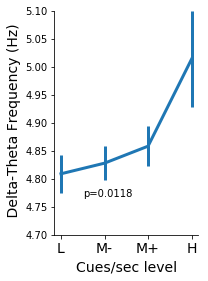

In [151]:
mmcs = dom_freq.groupby(['cuesec_w']).mean()['freq']
sscs = dom_freq.groupby(['cuesec_w']).sem()['freq']


fig = plt.figure()
ax = fig.add_subplot(111)

fig.set_figheight(4)
fig.set_figwidth(3)


# ax.errorbar( uni, mmcs, yerr=sscs, linewidth=3 )
ax.errorbar( range(mmcs.size), mmcs, yerr=sscs, linewidth=3 )
# ax.bar( range(mmcs.size), mmcs, yerr=sscs, color='grey' )

# sns.violinplot(data=log_wel_all.groupby(['cuesec']),  palette="Set3", bw=1.2, cut=2, linewidth=1 )


fig.patch.set_facecolor('xkcd:white')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.sca(ax)

plt.ylabel(' Delta-Theta Frequency (Hz)', fontsize=14)
plt.xlabel('Cues/sec level', fontsize=14)

plt.xticks(  range(mmcs.size), ['L','M-','M+','H'], fontsize=14 )

plt.tight_layout()


plt.ylim(4.7,5.1)

print( 'Pearson: ',  stats.pearsonr(dom_freq.cuesec, dom_freq.freq ))

cw_lm=ols('cuesec_w ~ freq', data=dom_freq).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=2))


ym = sum(plt.ylim())/2.055
pval_str =   'p=' + str(np.round(sm.stats.anova_lm(cw_lm, typ=2)['PR(>F)']['freq'],4))
plt.text( 0.5, ym, pval_str )




Pearson:  (0.0914395082034596, 0.009218260280762688)
             sum_sq     df         F    PR(>F)
freq        5.63117    1.0  6.369238  0.011802
Residual  714.36883  808.0       NaN       NaN
Pearson:  (0.0914395082034596, 0.009218260280762688)
              sum_sq     df         F    PR(>F)
kb          5.564057    1.0  6.292737  0.012318
Residual  714.435943  808.0       NaN       NaN
Pearson:  (0.0914395082034596, 0.009218260280762688)
                  sum_sq     df         F    PR(>F)
freq_kb_ratio    0.42275    1.0  0.474698  0.491032
Residual       719.57725  808.0       NaN       NaN


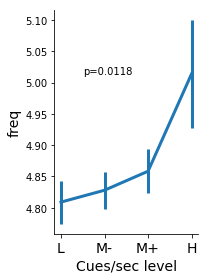

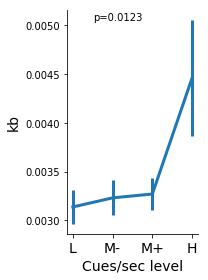

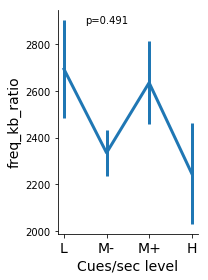

In [167]:
for var_of_interst in ['freq', 'kb', 'freq_kb_ratio']:
    mmcs = dom_freq.groupby(['cuesec_w']).mean()[var_of_interst]
    sscs = dom_freq.groupby(['cuesec_w']).sem()[var_of_interst]



    fig = plt.figure()
    ax = fig.add_subplot(111)
    fig.set_figheight(4)
    fig.set_figwidth(3)


    ax.errorbar( range(mmcs.size), mmcs, yerr=sscs, linewidth=3 )

    fig.patch.set_facecolor('xkcd:white')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.sca(ax)
    plt.ylabel(var_of_interst, fontsize=14)
    plt.xlabel('Cues/sec level', fontsize=14)
    plt.xticks(  range(mmcs.size), ['L','M-','M+','H'], fontsize=14 )
    plt.tight_layout()


    print( 'Pearson: ',  stats.pearsonr(dom_freq.cuesec, dom_freq.freq ))
    cw_lm=ols('cuesec_w ~ '+ var_of_interst, data=dom_freq).fit() #Specify C for Categorical
    print(sm.stats.anova_lm(cw_lm, typ=2))


    ym = plt.ylim()[1]*0.98 #sum(plt.ylim())/2.01
    pval_str =   'p=' + str(np.round(sm.stats.anova_lm(cw_lm, typ=2)['PR(>F)'][var_of_interst],4))
    plt.text( 0.5, ym, pval_str )

In [101]:

stats.pearsonr(dom_freq['kb'] , dom_freq['freq'] )

(0.07816030125696524, 0.02611820833199536)

In [177]:
# fig = plt.figure()
# ax = fig.add_subplot(111)
# fig.set_figheight(4)
# fig.set_figwidth(6)

dom_freq_np = dom_freq.to_numpy()

tmp = []
for sub in range(8):
    tmp_tmp = [] 
    for cuesec in np.sort(np.unique(dom_freq_np[:,3])):
#     for cuesec in range(9):
        idx = np.where(  np.logical_and( dom_freq_np[:,0]==sub, dom_freq_np[:,3]==cuesec )   )
        mmmm1 = np.mean( dom_freq_np[idx,5] )
        mmmm2 = np.mean( dom_freq_np[idx,6] )

        tmp_tmp.append( [mmmm1,mmmm2] )
    tmp.append(tmp_tmp)
tmp = np.array(tmp)


# # plt.errorbar( uni, np.average(tmp,axis=0), stats.sem(tmp,axis=0), linewidth=3 )
# plt.errorbar( range(4), np.average(tmp,axis=0), stats.sem(tmp,axis=0), linewidth=3 )
# print( stats.pearsonr(np.tile(np.arange(4),8) , tmp.flatten() ) )

    
# fig.patch.set_facecolor('xkcd:white')
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# plt.xlabel('Condition', fontsize=16)
# plt.ylabel('Dominant frequency', fontsize=16)
# # plt.xticks(range(3), ['Low','Med','High'])

In [175]:
dom_freq.head()

,sub,density,speed,cuesec,cuesec_w,freq,kb,freq_kb_ratio
0,0.0,0.0,0.0,2.762431,0.0,4.778667,0.011232,425.452719
1,0.0,0.0,1.0,3.703704,0.0,4.437333,0.001110,3999.079509
2,0.0,0.0,2.0,4.545455,1.0,4.778667,0.003496,1366.837113
3,0.0,1.0,0.0,5.524862,1.0,4.778667,0.001992,2398.668197
4,0.0,1.0,1.0,7.407407,1.0,4.778667,0.002134,2239.710401


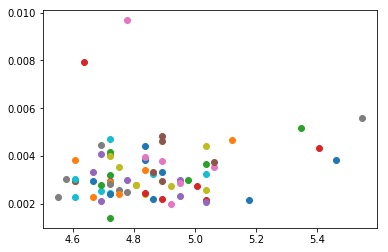

In [178]:
for sub in range(tmp.shape[0]):
#     tmp[sub] = stats.zscore(tmp[sub],axis=1)
    for cond in range(tmp[sub].shape[0]):
        plt.plot(tmp[sub][cond][0],tmp[sub][cond][1], 'o')

In [180]:
stats.pearsonr(tmp.reshape((8*9,2))[:,0], tmp.reshape((8*9,2))[:,1])

(0.16162435637856643, 0.17498378815641)

In [181]:
for sub in range(8):
    idx = np.where( dom_freq_np[:,0]==sub )[0]
    print(   stats.pearsonr(  dom_freq_np[idx,5], dom_freq_np[idx,6] )  )

(0.027919087911830655, 0.7742475246441987)
(0.4404851492738993, 1.8363286726937144e-06)
(-0.06220330706746804, 0.5224759713107816)
(-0.14012847718320234, 0.14804827484690983)
(0.11933479466699544, 0.21864693576328392)
(0.06580239381987651, 0.49865017902851394)
(-0.13391634523382293, 0.16705223092712027)
(-0.1564954243581554, 0.25844552765025486)


# Count Gamma events

In [216]:
low_amp_freq,high_amp_freq = 55,95

sub = 5
    
### Load this session dataset
lfp = loadmat('../Data/'+sessions[sub]+'.mat')
lfp = lfp['ourData']

    
    
cc =  hpc_electrodes[sub][0]
        

tmp_lfp = lfp[cc]         

tmp_lfp_notch = mne.filter.notch_filter( np.float64(tmp_lfp), fs, [50,100,150,200], notch_widths=20 )

gamma_amp   = hilbert_transform_get_component(tmp_lfp_notch, fs, low_amp_freq,high_amp_freq, 'amplitude')
theta_phase = hilbert_transform_get_component(tmp_lfp_notch, fs, 2,8, 'phase')
gamma_phase = hilbert_transform_get_component(tmp_lfp_notch, fs, low_amp_freq,high_amp_freq, 'phase')

Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=205501
    Range : 0 ... 205500 =      0.000 ...   401.367 secs
Ready.
Setting up band-pass filter from 55 - 95 Hz
Filter length of 845 samples (1.650 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=205501
    Range : 0 ... 205500 =      0.000 ...   401.367 secs
Ready.
Setting up band-pass filter from 2 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=205501
    Range : 0 ... 205500 =      0.000 ...   401.367 secs
Ready.
Setting up band-pass filter from 55 - 95 Hz
Filter length of 845 samples (1.650 sec) selected


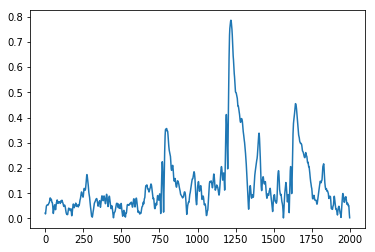

In [219]:
plt.plot(gamma_amp[15000:17000])

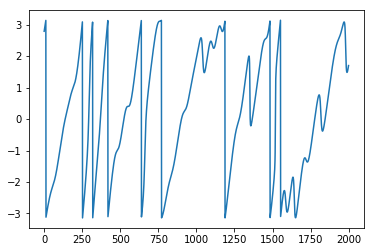

In [220]:
plt.plot(theta_phase[15000:17000])

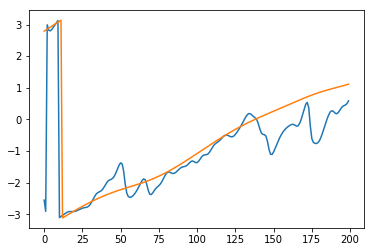

In [221]:
plt.plot(gamma_phase[15000:15200])
plt.plot(theta_phase[15000:15200])

In [217]:
psd = mne.time_frequency.psd_array_multitaper(tmp_lfp, fs)

    Using multitaper spectrum estimation with 7 DPSS windows


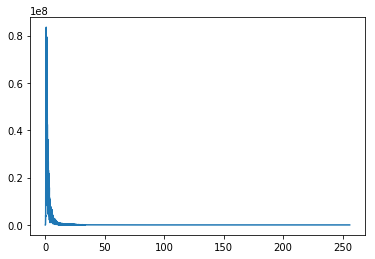

In [218]:
plt.plot(psd[1],psd[0])
# plt.xlim(0,30)

In [222]:
sessions

['Eugeni_s2',
 'Eugeni_s3',
 'JCQ_s1',
 'JCQ_s2',
 'JS_s1',
 'JS_s2',
 'JS_s3',
 'MRI_s2']

In [272]:
lfp_d = loadmat('../Data/controls/A_NA_monopolar.mat')
# lfp_d = lfp_d['A_NA'][0,0][0]

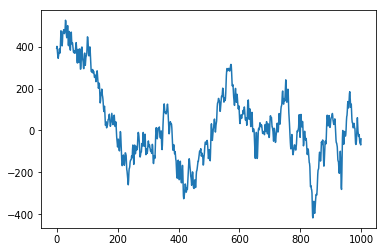

In [277]:
# plt.plot(lfp_d['A_NA'][0,0][0][:10000])
plt.plot(lfp_d['A_NA'][0,0][0][:1000])

In [289]:
psd = mne.time_frequency.psd_array_welch(lfp_d['A_NA'][0,3][0], fs)

Effective window size : 0.500 (s)


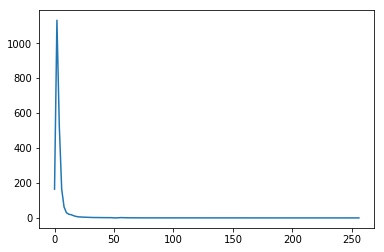

In [290]:
plt.plot(psd[1],psd[0])

In [249]:
sessions

['Eugeni_s2',
 'Eugeni_s3',
 'JCQ_s1',
 'JCQ_s2',
 'JS_s1',
 'JS_s2',
 'JS_s3',
 'MRI_s2']

In [19]:
def preoper(x, threshold=0.001):
    """Threshold the TTL signal"""
    x[x<threshold] = 0
    x[x>threshold] = 1
    return x

def abs_events(x):
    """Determine events onset/offset"""
    out = np.diff(np.abs(np.hstack((x, x[-1]))))
    out[out<0] = 0
    return out 

def invert_polarity(x):
    out = -x
    return out

In [57]:
edf_struct

{0: {'subject': 0,
  'filename': '/Volumes/Elements/normaliser_edf_data/14_04_16.edf',
  'start': 140000,
  'end': 350000,
  'ttl': 120},
 1: {'subject': 0,
  'filename': '/Volumes/Elements/normaliser_edf_data/18_04_16.edf',
  'start': 350000,
  'end': 560000,
  'ttl': 120},
 2: {'subject': 0,
  'filename': '/Volumes/Elements/normaliser_edf_data/20_04_16.edf',
  'start': 950000,
  'end': 1155000,
  'ttl': 120},
 3: {'subject': 1,
  'filename': '/Volumes/Elements/normaliser_edf_data/030416.edf',
  'start': 2300000,
  'end': 2520000,
  'ttl': 125},
 4: {'subject': 1,
  'filename': '/Volumes/Elements/normaliser_edf_data/040416.edf',
  'start': 50000,
  'end': 255000,
  'ttl': 125},
 5: {'subject': 2,
  'filename': '/Volumes/Elements/normaliser_edf_data/CQJ0.edf',
  'start': 2300000,
  'end': 2520000,
  'ttl': 125},
 6: {'subject': 3,
  'filename': '/Volumes/Elements/normaliser_edf_data/eugeni_090716.edf',
  'start': 151000,
  'end': 342000,
  'ttl': 123},
 7: {'subject': 3,
  'filename': 

In [59]:
filename = '/Volumes/Elements/normaliser_edf_data/BLASCOBLANCO_NORMALIZER.edf'
raw = mne.io.read_raw_edf(filename, preload=False)

Extracting EDF parameters from /Volumes/Elements/normaliser_edf_data/BLASCOBLANCO_NORMALIZER.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-59-e59a10c65e10>:2: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_edf(filename, preload=False)


In [43]:
TTL_ch = None
TTL_ch_name = 'TTL'
for ii in range(len(raw.info['ch_names'])):
    if raw.info['ch_names'][ii] == TTL_ch_name: TTL_ch = ii
print(TTL_ch)

120


In [13]:
raw_data = raw.get_data(picks=[TTL_ch] )
raw_data = raw_data[0]

In [517]:
raw_data = mne.filter.notch_filter(raw_data, raw.info['sfreq'], [50,100,150,200], notch_widths=2)

Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected


In [15]:
%matplotlib

# ii = 0
# sss = int(raw_data.shape[0]/10 * ii)
# eee = int(raw_data.shape[0]/10 * (ii+1))
# plt.plot(raw_data_notched[ sss:eee ])

plt.plot(raw_data)

Using matplotlib backend: TkAgg


In [487]:
raw_data.shape

(2158184,)

In [44]:
ev = mne.find_events(raw, stim_channel=TTL_ch_name, output='onset', 
                     initial_event=True, shortest_event=1/raw.info['sfreq'])


In [477]:
plt.plot(raw_data[0])

In [73]:
raw.apply_function(preoper, picks=[TTL_ch])
raw.apply_function(abs_events, picks=[TTL_ch])

RuntimeError: By default, MNE does not load data into main memory to conserve resources. raw.apply_function requires raw data to be loaded. Use preload=True (or string) in the constructor or raw.load_data().

In [37]:
ev = mne.find_events(raw, stim_channel=TTL_ch_name, output='onset')


In [78]:
raw_data = raw.get_data()

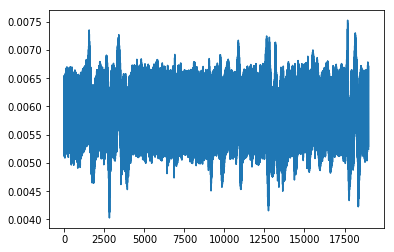

In [91]:
plt.plot(raw_data[50][1000:20000])
# np.where(raw_data[0]>0)